In [1]:
import json
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import jsonlines
import altair as alt
from vega_datasets import data



os.chdir("../")

SRC_PATH = ["src"]
for module_path in SRC_PATH:
    if module_path not in sys.path:
        sys.path.append(module_path)

from utils import *

# TPR for all trained detectors

In [2]:
dataset_names = ["phi", "gemma", "mistral", "gemma_chat", "zephyr", "llama3", "round_robin"]
training_method = "full_finetuning"
trained_on_models = {"distil_roberta-base": {"10_06_1040": "phi", "10_06_1047": "gemma", "10_06_1054": "mistral", "10_06_1100": "round_robin"},
                    "roberta_large": {"10_06_1156": "phi", "10_06_1221": "gemma", "10_06_1246": "mistral", "10_06_1312": "round_robin"},
                    "electra_large": {"10_06_1146": "phi", "10_06_1215": "gemma", "10_06_1242": "mistral", "10_06_1308": "round_robin"}}


freeze_base_df = create_df_from_test_logs("full_finetuning", trained_on_models, dataset_names, use_test_at_threshold=True)

freeze_base_df = freeze_base_df.sort_values(by="trained_on_dataset")
dataset_order = ["phi", "gemma", "mistral", "round_robin", "gemma_chat", "zephyr", "llama3"]
freeze_base_df = freeze_base_df.set_index("dataset").loc[dataset_order].reset_index()
detector_name_to_short_name = {"distil_roberta-base": "distil", "roberta_large": "roberta", "electra_large": "electra"}
freeze_base_df["detector_short_name"] = freeze_base_df["base_detector"].apply(lambda x: detector_name_to_short_name[x])
# set detector_name as f"{detector_short_name}_{trained_on_dataset}"
freeze_base_df["detector_name"] = freeze_base_df["detector_short_name"] + "_" + freeze_base_df["trained_on_dataset"]
freeze_base_df.head()

dataset  accuracy  precision    recall  f1_score   fp_rate   tp_rate  \
0     phi  0.946570   0.916307  0.982998  0.948458  0.089908  0.982998   
1     phi  0.964892   0.963227  0.966731  0.964959  0.036942  0.966731   
2     phi  0.941804   0.925778  0.960711  0.942895  0.077127  0.960711   
3     phi  0.966051   0.956237  0.976857  0.966420  0.044763  0.976857   
4     phi  0.951109   0.917786  0.991064  0.952998  0.088907  0.991064   

   std_accuracy  std_precision  std_recall  ...  \
0      0.004918       0.008360    0.004118  ...   
1      0.004012       0.005942    0.005582  ...   
2      0.005395       0.008341    0.006190  ...   
3      0.003977       0.006481    0.004665  ...   
4      0.004701       0.008208    0.002856  ...   

   std_tp_rate_at_given_threshold  TP_at_given_threshold  \
0                        0.006015                957.251   
1                        0.004729                973.021   
2                        0.007422                942.343   
3                        0.004707                972.198   
4                        0.004597                973.233   

   TN_at_given_threshold  FP_at_given_threshold  FN_at_given_threshold  \
0                946.022                 50.853                 37.874   
1                947.908                 48.967                 22.104   
2                941.884                 54.991                 52.782   
3                952.766                 44.109                 22.927   
4                947.736                 49.139                 21.892   

         base_detector  trained_on_dataset                   detector  \
0        roberta_large               gemma        roberta_large_gemma   
1        electra_large               gemma        electra_large_gemma   
2  distil_roberta-base               gemma  distil_roberta-base_gemma   
3        electra_large             mistral      electra_large_mistral   
4        roberta_large             mistral      roberta_large_mistral   

  detector_short_name    detector_name  
0             roberta    roberta_gemma  
1             electra    electra_gemma  
2              distil     distil_gemma  
3             electra  electra_mistral  
4             roberta  roberta_mistral  

[5 rows x 43 columns]

In [3]:
# rename column "tp_rate_at_given_threshold"
freeze_base_df = freeze_base_df.rename(columns={"tp_rate_at_given_threshold": "TPR"})

In [4]:
heatmap = alt.Chart(freeze_base_df).mark_rect().encode(
    alt.X('dataset:N', sort=None, title="Dataset used for testing"),
    alt.Y('detector_short_name:N', sort=None, title="Detector"),
    alt.Color('TPR:Q').scale(scheme='redyellowgreen', domain=[0.85, 1]),
    #alt.Row("trained_on_dataset:N", title="Dataset used for training"),
).properties(
    width=200,
    height=200
)

heatmap_text = alt.Chart(freeze_base_df).mark_text(baseline='middle').encode(
    alt.X('dataset:N', sort=None, title="Dataset used for testing"),
    alt.Y('detector_short_name:N', sort=None, title="Detector"),
    text='TPR:Q',
    color=alt.condition(
        alt.datum.TPR > 0.5,
        alt.value('black'),
        alt.value('white')
    )
).properties(
    width=200,
    height=200
)

plot = alt.layer(heatmap, heatmap_text).facet(
    column=alt.Column("trained_on_dataset:N", title="Dataset used for training")
).configure(
    numberFormat='0.2f'
).configure_axis(
    labelFontSize=18,
    titleFontSize=18
).configure_legend(
    labelFontSize=18,
    titleFontSize=18
).configure_header(
    titleFontSize=18,
    labelFontSize=18
)

# save the plot
plot.save("notebooks/plots/heatmap_full.png")

plot

alt.FacetChart(...)

# AUROC/Accuracy for all training methods

## Freeze base

In [5]:
dataset_names = ["phi", "gemma", "mistral", "gemma_chat", "zephyr", "llama3", "round_robin"]
training_method = "full_finetuning"
trained_on_models = {"distil_roberta-base": {"10_06_1012": "phi", "10_06_1016": "gemma", "10_06_1020": "mistral", "10_06_1023": "round_robin"},
                    "roberta_large": {"10_06_1012": "phi", "10_06_1028": "gemma", "10_06_1043": "mistral", "10_06_1055": "round_robin"},
                    "electra_large": {"10_06_1012": "phi", "10_06_1024": "gemma", "10_06_1036": "mistral", "10_06_1048": "round_robin"}}


freeze_base_df = create_df_from_test_logs("freeze_base", trained_on_models, dataset_names)

freeze_base_df = freeze_base_df.sort_values(by="trained_on_dataset")
dataset_order = ["phi", "gemma", "mistral", "round_robin", "gemma_chat", "zephyr", "llama3"]
freeze_base_df = freeze_base_df.set_index("dataset").loc[dataset_order].reset_index()
detector_name_to_short_name = {"distil_roberta-base": "distil", "roberta_large": "roberta", "electra_large": "electra"}
freeze_base_df["detector_short_name"] = freeze_base_df["base_detector"].apply(lambda x: detector_name_to_short_name[x])
# set detector_name as f"{detector_short_name}_{trained_on_dataset}"
freeze_base_df["detector_name"] = freeze_base_df["detector_short_name"] + "_" + freeze_base_df["trained_on_dataset"]
freeze_base_df.head()

dataset  accuracy  precision    recall  f1_score   fp_rate   tp_rate  \
0     phi  0.845974   0.904199  0.774220  0.834097  0.082139  0.774220   
1     phi  0.877273   0.827359  0.953711  0.886009  0.199274  0.953711   
2     phi  0.848685   0.820615  0.892737  0.855100  0.195424  0.892737   
3     phi  0.870327   0.828773  0.933753  0.878086  0.193184  0.933753   
4     phi  0.848320   0.871880  0.816918  0.843432  0.120236  0.816918   

   std_accuracy  std_precision  std_recall  ...       FN   roc_auc  \
0      0.008394       0.010235    0.013788  ...  225.063  0.921470   
1      0.006932       0.010719    0.006694  ...   46.138  0.964493   
2      0.007664       0.011478    0.009473  ...  106.916  0.928286   
3      0.007212       0.010917    0.008120  ...   66.036  0.953634   
4      0.008420       0.011026    0.012932  ...  182.489  0.925994   

                                   fpr_at_thresholds  \
0  [0.0, 0.0, 0.0, 0.001004016064257028, 0.001004...   
1  [0.0, 0.0, 0.0, 0.001004016064257028, 0.001004...   
2  [0.0, 0.0, 0.0, 0.001004016064257028, 0.001004...   
3  [0.0, 0.0, 0.0, 0.001004016064257028, 0.001004...   
4  [0.0, 0.0, 0.0, 0.001004016064257028, 0.001004...   

                                   tpr_at_thresholds  \
0  [0.0, 0.001004016064257028, 0.3132530120481928...   
1  [0.0, 0.001004016064257028, 0.3463855421686747...   
2  [0.0, 0.001004016064257028, 0.1636546184738956...   
3  [0.0, 0.001004016064257028, 0.2369477911646586...   
4  [0.0, 0.001004016064257028, 0.2680722891566265...   

                                          thresholds        base_detector  \
0  [inf, 3.2750465869903564, 1.0057134628295898, ...        roberta_large   
1  [inf, 5.716957092285156, 2.1009159088134766, 2...        electra_large   
2  [inf, 3.8231215476989746, 1.7784489393234253, ...  distil_roberta-base   
3  [inf, 3.7220797538757324, 1.355473518371582, 1...        electra_large   
4  [inf, 3.560633659362793, 1.4908324480056763, 1...        roberta_large   

   trained_on_dataset                   detector detector_short_name  \
0               gemma        roberta_large_gemma             roberta   
1               gemma        electra_large_gemma             electra   
2               gemma  distil_roberta-base_gemma              distil   
3             mistral      electra_large_mistral             electra   
4             mistral      roberta_large_mistral             roberta   

     detector_name  
0    roberta_gemma  
1    electra_gemma  
2     distil_gemma  
3  electra_mistral  
4  roberta_mistral  

[5 rows x 26 columns]

In [6]:
heatmap = alt.Chart(freeze_base_df).mark_rect().encode(
    alt.X('dataset:N', sort=None, title="Dataset used for testing"),
    alt.Y('detector_short_name:N', sort=None, title="Detector"),
    alt.Color('roc_auc:Q').scale(scheme='redyellowgreen', domain=[0.85, 1]),
    #alt.Row("trained_on_dataset:N", title="Dataset used for training"),
).properties(
    width=200,
    height=200
)

heatmap_text = alt.Chart(freeze_base_df).mark_text(baseline='middle').encode(
    alt.X('dataset:N', sort=None, title="Dataset used for testing"),
    alt.Y('detector_short_name:N', sort=None, title="Detector"),
    text='roc_auc:Q',
    color=alt.condition(
        alt.datum.roc_auc > 0.5,
        alt.value('black'),
        alt.value('white')
    )
).properties(
    width=200,
    height=200
)

plot = alt.layer(heatmap, heatmap_text).facet(
    column=alt.Column("trained_on_dataset:N", title="Dataset used for training")
).configure(
    numberFormat='0.2f'
).configure_axis(
    labelFontSize=18,
    titleFontSize=18
).configure_legend(
    labelFontSize=18,
    titleFontSize=18
).configure_header(
    titleFontSize=18,
    labelFontSize=18
)

# save the plot
plot.save("notebooks/plots/heatmap_full_freeze_base_roc_auc.png")

plot

alt.FacetChart(...)

# Adapter  

In [7]:
dataset_names = ["phi", "gemma", "mistral", "gemma_chat", "zephyr", "llama3", "round_robin"]
training_method = "full_finetuning"
trained_on_models = {"distil_roberta-base": {"10_06_1026": "phi", "10_06_1030": "gemma", "10_06_1034": "mistral", "10_06_1037": "round_robin"},
                    "roberta_large": {"10_06_1103": "phi", "10_06_1117": "gemma", "10_06_1133": "mistral", "10_06_1148": "round_robin"},
                    "electra_large": {"10_06_1054": "phi", "10_06_1110": "gemma", "10_06_1125": "mistral", "10_06_1140": "round_robin"}}


freeze_base_df = create_df_from_test_logs("adapter", trained_on_models, dataset_names)

freeze_base_df = freeze_base_df.sort_values(by="trained_on_dataset")
dataset_order = ["phi", "gemma", "mistral", "round_robin", "gemma_chat", "zephyr", "llama3"]
freeze_base_df = freeze_base_df.set_index("dataset").loc[dataset_order].reset_index()
detector_name_to_short_name = {"distil_roberta-base": "distil", "roberta_large": "roberta", "electra_large": "electra"}
freeze_base_df["detector_short_name"] = freeze_base_df["base_detector"].apply(lambda x: detector_name_to_short_name[x])
# set detector_name as f"{detector_short_name}_{trained_on_dataset}"
freeze_base_df["detector_name"] = freeze_base_df["detector_short_name"] + "_" + freeze_base_df["trained_on_dataset"]
freeze_base_df.head()

dataset  accuracy  precision    recall  f1_score   fp_rate   tp_rate  \
0     phi  0.924573   0.880980  0.981916  0.928681  0.132857  0.981916   
1     phi  0.949507   0.952907  0.945825  0.949329  0.046804  0.945825   
2     phi  0.927416   0.898483  0.963838  0.929981  0.109056  0.963838   
3     phi  0.928011   0.884394  0.984858  0.931898  0.128923  0.984858   
4     phi  0.929205   0.891099  0.978052  0.932523  0.119717  0.978052   

   std_accuracy  std_precision  std_recall  ...      FN   roc_auc  \
0      0.005782       0.009714    0.004228  ...  18.024  0.986660   
1      0.004979       0.006973    0.007030  ...  53.995  0.990705   
2      0.005850       0.009406    0.006018  ...  36.043  0.980771   
3      0.005715       0.009397    0.003838  ...  15.092  0.988310   
4      0.005798       0.009455    0.004577  ...  21.880  0.985486   

                                   fpr_at_thresholds  \
0  [0.0, 0.0, 0.0, 0.001004016064257028, 0.001004...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.001004016064257028...   
2  [0.0, 0.0, 0.0, 0.001004016064257028, 0.001004...   
3  [0.0, 0.0, 0.0, 0.001004016064257028, 0.001004...   
4  [0.0, 0.0, 0.0, 0.001004016064257028, 0.001004...   

                                   tpr_at_thresholds  \
0  [0.0, 0.001004016064257028, 0.5341365461847389...   
1  [0.0, 0.001004016064257028, 0.2740963855421687...   
2  [0.0, 0.001004016064257028, 0.4407630522088353...   
3  [0.0, 0.001004016064257028, 0.4939759036144578...   
4  [0.0, 0.001004016064257028, 0.3624497991967871...   

                                          thresholds        base_detector  \
0  [inf, 6.0513997077941895, 3.689751386642456, 3...        roberta_large   
1  [inf, 4.866688251495361, 3.1433632373809814, 3...        electra_large   
2  [inf, 4.8516526222229, 1.959630012512207, 1.95...  distil_roberta-base   
3  [inf, 4.010010242462158, 2.3876678943634033, 2...        electra_large   
4  [inf, 6.621685028076172, 2.6032674312591553, 2...        roberta_large   

   trained_on_dataset                   detector detector_short_name  \
0               gemma        roberta_large_gemma             roberta   
1               gemma        electra_large_gemma             electra   
2               gemma  distil_roberta-base_gemma              distil   
3             mistral      electra_large_mistral             electra   
4             mistral      roberta_large_mistral             roberta   

     detector_name  
0    roberta_gemma  
1    electra_gemma  
2     distil_gemma  
3  electra_mistral  
4  roberta_mistral  

[5 rows x 26 columns]

In [8]:
heatmap = alt.Chart(freeze_base_df).mark_rect().encode(
    alt.X('dataset:N', sort=None, title="Dataset used for testing"),
    alt.Y('detector_short_name:N', sort=None, title="Detector"),
    alt.Color('roc_auc:Q').scale(scheme='redyellowgreen', domain=[0.85, 1]),
    #alt.Row("trained_on_dataset:N", title="Dataset used for training"),
).properties(
    width=200,
    height=200
)

heatmap_text = alt.Chart(freeze_base_df).mark_text(baseline='middle').encode(
    alt.X('dataset:N', sort=None, title="Dataset used for testing"),
    alt.Y('detector_short_name:N', sort=None, title="Detector"),
    text='roc_auc:Q',
    color=alt.condition(
        alt.datum.roc_auc > 0.5,
        alt.value('black'),
        alt.value('white')
    )
).properties(
    width=200,
    height=200
)

plot = alt.layer(heatmap, heatmap_text).facet(
    column=alt.Column("trained_on_dataset:N", title="Dataset used for training")
).configure(
    numberFormat='0.2f'
).configure_axis(
    labelFontSize=18,
    titleFontSize=18
).configure_legend(
    labelFontSize=18,
    titleFontSize=18
).configure_header(
    titleFontSize=18,
    labelFontSize=18
)

# save the plot
plot.save("notebooks/plots/heatmap_full_adapter_roc_auc.png")

plot

alt.FacetChart(...)

In [9]:
dataset_names = ["phi", "gemma", "mistral", "gemma_chat", "zephyr", "llama3", "round_robin"]
training_method = "full_finetuning"
trained_on_models = {"distil_roberta-base": {"10_06_1040": "phi", "10_06_1047": "gemma", "10_06_1054": "mistral", "10_06_1100": "round_robin"},
                    "roberta_large": {"10_06_1156": "phi", "10_06_1221": "gemma", "10_06_1246": "mistral", "10_06_1312": "round_robin"},
                    "electra_large": {"10_06_1146": "phi", "10_06_1215": "gemma", "10_06_1242": "mistral", "10_06_1308": "round_robin"}}


freeze_base_df = create_df_from_test_logs("full_finetuning", trained_on_models, dataset_names, use_test_at_threshold=True)

freeze_base_df = freeze_base_df.sort_values(by="trained_on_dataset")
dataset_order = ["phi", "gemma", "mistral", "round_robin", "gemma_chat", "zephyr", "llama3"]
freeze_base_df = freeze_base_df.set_index("dataset").loc[dataset_order].reset_index()
detector_name_to_short_name = {"distil_roberta-base": "distil", "roberta_large": "roberta", "electra_large": "electra"}
freeze_base_df["detector_short_name"] = freeze_base_df["base_detector"].apply(lambda x: detector_name_to_short_name[x])
# set detector_name as f"{detector_short_name}_{trained_on_dataset}"
freeze_base_df["detector_name"] = freeze_base_df["detector_short_name"] + "_" + freeze_base_df["trained_on_dataset"]
freeze_base_df.head()

dataset  accuracy  precision    recall  f1_score   fp_rate   tp_rate  \
0     phi  0.946570   0.916307  0.982998  0.948458  0.089908  0.982998   
1     phi  0.964892   0.963227  0.966731  0.964959  0.036942  0.966731   
2     phi  0.941804   0.925778  0.960711  0.942895  0.077127  0.960711   
3     phi  0.966051   0.956237  0.976857  0.966420  0.044763  0.976857   
4     phi  0.951109   0.917786  0.991064  0.952998  0.088907  0.991064   

   std_accuracy  std_precision  std_recall  ...  \
0      0.004918       0.008360    0.004118  ...   
1      0.004012       0.005942    0.005582  ...   
2      0.005395       0.008341    0.006190  ...   
3      0.003977       0.006481    0.004665  ...   
4      0.004701       0.008208    0.002856  ...   

   std_tp_rate_at_given_threshold  TP_at_given_threshold  \
0                        0.006015                957.251   
1                        0.004729                973.021   
2                        0.007422                942.343   
3                        0.004707                972.198   
4                        0.004597                973.233   

   TN_at_given_threshold  FP_at_given_threshold  FN_at_given_threshold  \
0                946.022                 50.853                 37.874   
1                947.908                 48.967                 22.104   
2                941.884                 54.991                 52.782   
3                952.766                 44.109                 22.927   
4                947.736                 49.139                 21.892   

         base_detector  trained_on_dataset                   detector  \
0        roberta_large               gemma        roberta_large_gemma   
1        electra_large               gemma        electra_large_gemma   
2  distil_roberta-base               gemma  distil_roberta-base_gemma   
3        electra_large             mistral      electra_large_mistral   
4        roberta_large             mistral      roberta_large_mistral   

  detector_short_name    detector_name  
0             roberta    roberta_gemma  
1             electra    electra_gemma  
2              distil     distil_gemma  
3             electra  electra_mistral  
4             roberta  roberta_mistral  

[5 rows x 43 columns]

In [10]:
heatmap = alt.Chart(freeze_base_df).mark_rect().encode(
    alt.X('dataset:N', sort=None, title="Dataset used for testing"),
    alt.Y('detector_short_name:N', sort=None, title="Detector"),
    alt.Color('roc_auc:Q').scale(scheme='redyellowgreen', domain=[0.85, 1]),
    #alt.Row("trained_on_dataset:N", title="Dataset used for training"),
).properties(
    width=200,
    height=200
)

heatmap_text = alt.Chart(freeze_base_df).mark_text(baseline='middle').encode(
    alt.X('dataset:N', sort=None, title="Dataset used for testing"),
    alt.Y('detector_short_name:N', sort=None, title="Detector"),
    text='roc_auc:Q',
    color=alt.condition(
        alt.datum.roc_auc > 0.5,
        alt.value('black'),
        alt.value('white')
    )
).properties(
    width=200,
    height=200
)

plot = alt.layer(heatmap, heatmap_text).facet(
    column=alt.Column("trained_on_dataset:N", title="Dataset used for training")
).configure(
    numberFormat='0.2f'
).configure_axis(
    labelFontSize=18,
    titleFontSize=18
).configure_legend(
    labelFontSize=18,
    titleFontSize=18
).configure_header(
    titleFontSize=18,
    labelFontSize=18
)

# save the plot
plot.save("notebooks/plots/heatmap_full_full_finetuning_roc_auc.png")
plot.save("notebooks/plots/heatmap_full_full_finetuning_roc_auc.pdf")


plot

alt.FacetChart(...)

# Checking degradation

In [11]:
detector = "distil_roberta-base"
training_method = "adapter"
model_code = "02_05_1424"
eval_acc_df_distil_adapter, degrad_loss_df_distil_adapter, training_loss_df_distil_adapter = create_df_from_training_logs(detector, training_method, model_code)

detector = "distil_roberta-base"
training_method = "full_finetuning"
model_code = "02_05_1431"
eval_acc_df_distil_full, degrad_loss_df_distil_full, training_loss_df_distil_full = create_df_from_training_logs(detector, training_method, model_code)

detector = "roberta_large"
training_method = "adapter"
model_code = "30_04_1008"
eval_acc_df_large_adapter, degrad_loss_df_large_adapter, training_loss_df_large_adapter = create_df_from_training_logs(detector, training_method, model_code)

detector = "roberta_large"
training_method = "full_finetuning"
model_code = "02_05_1419"
eval_acc_df_large_full, degrad_loss_df_large_full, training_loss_df_large_full = create_df_from_training_logs(detector, training_method, model_code)

In [12]:
plot_panel_model_and_training_method_eval_acc(eval_acc_df_distil_adapter, eval_acc_df_distil_full, eval_acc_df_large_adapter, eval_acc_df_large_full, save=True)

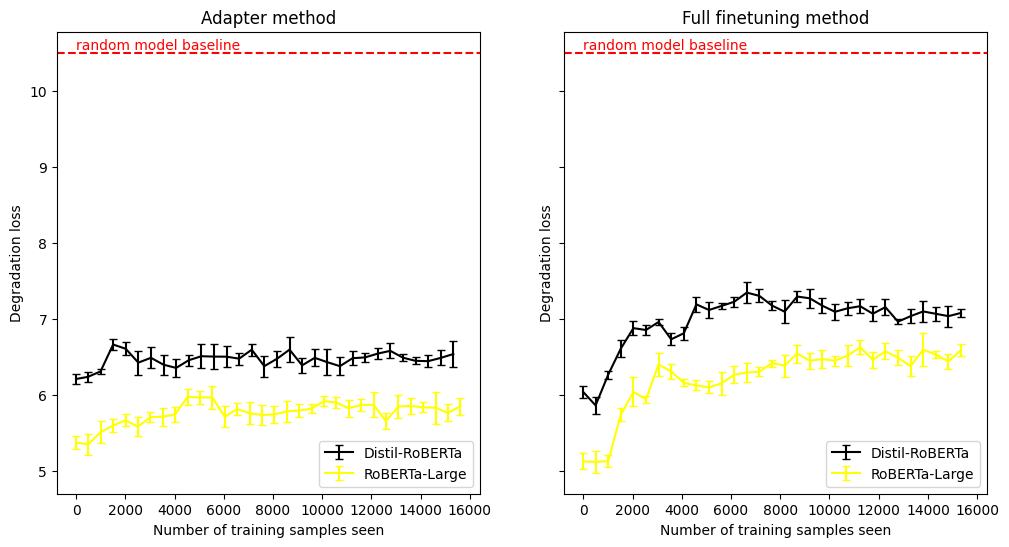

In [13]:
plot_panel_model_and_training_method_degrad(degrad_loss_df_distil_adapter, degrad_loss_df_distil_full, degrad_loss_df_large_adapter, degrad_loss_df_large_full, save=True)

# GPTZero

In [27]:
fast_detect_gpt_results = {"fast_detect_gpt": {"07_05_0942" : "phi", "07_05_0949" : "gemma", "07_05_0956" : "mistral", "07_05_1003" : "round_robin",
                           "07_05_1007": "gemma_chat", "07_05_1014" : "zephyr", "07_05_1020" : "llama3"}}
roberta_open_ai_results = {"roberta_base_open_ai": {"06_05_1716" : "phi", "06_05_1718" : "gemma", "06_05_1719" : "mistral", "06_05_1721" : "round_robin",
                           "06_05_1723": "gemma_chat", "06_05_1724" : "zephyr", "06_05_1726" : "llama3"}}
gpt_zero_results = {"gpt_zero": {"06_05_1716" : "phi", "06_05_1718" : "gemma", "06_05_1719" : "mistral", "06_05_1721" : "round_robin",
                           "06_05_1723": "gemma_chat", "06_05_1724" : "zephyr", "06_05_1726" : "llama3"}}
freeze_base_df = create_df_from_test_logs("full_finetuning", trained_on_models, dataset_names, use_test_at_threshold=True)

freeze_base_df = add_test_logs_to_results_df(freeze_base_df, fast_detect_gpt_results, use_timestamp=False, use_test_at_threshold=True)
freeze_base_df = add_test_logs_to_results_df(freeze_base_df, roberta_open_ai_results, use_timestamp=False, use_test_at_threshold=True)
freeze_base_df = add_test_logs_to_results_df(freeze_base_df, gpt_zero_results, use_timestamp=False, use_eval_split=True)

# create detector_short_name column for the new detectors
detector_name_to_short_name = {"distil_roberta-base": "distil", "roberta_large": "roberta", "electra_large": "electra",
                               "fast_detect_gpt": "fast_detect_gpt", "roberta_base_open_ai": "roberta_open_ai", "gpt_zero": "gpt_zero"}
freeze_base_df["detector_short_name"] = freeze_base_df["base_detector"].apply(lambda x: detector_name_to_short_name[x])

In [28]:
# rename column "tp_rate_at_given_threshold"
freeze_base_df = freeze_base_df.rename(columns={"tp_rate_at_given_threshold": "TPR"})

In [32]:
zero_shot_only_only_df

accuracy  precision    recall  f1_score   fp_rate   tp_rate  std_accuracy  \
59  0.953286   0.978922  0.926579  0.952010  0.019980  0.926579      0.004493   
61  0.960558   0.979242  0.941125  0.959786  0.019980  0.941125      0.004237   
60  0.907045   0.981291  0.829921  0.899226  0.015823  0.829921      0.007131   
4   0.942560   0.919568  0.969980  0.944078  0.084889  0.969980      0.005252   
5   0.915259   0.913374  0.917586  0.915431  0.087057  0.917586      0.006399   
6   0.950572   0.921064  0.985714  0.952273  0.084642  0.985714      0.004677   
4   0.795837   0.885427  0.679967  0.769116  0.088105  0.679967      0.009095   
5   0.662844   0.827343  0.411644  0.549574  0.085923  0.411644      0.011061   
6   0.778589   0.880036  0.645485  0.744618  0.088105  0.645485      0.009445   
4   0.924398   0.992892  0.855060  0.918798  0.006131  0.855060      0.005884   
5   0.811073   0.992834  0.626988  0.768493  0.004534  0.626988      0.008531   
6   0.873062   0.992082  0.752202  0.855580  0.006011  0.752202      0.007451   

    std_precision  std_recall  std_f1_score  ...  TN_at_given_threshold  \
59       0.004595    0.007939      0.004789  ...                954.908   
61       0.004523    0.007342      0.004415  ...                952.908   
60       0.004795    0.012847      0.008072  ...                843.477   
4        0.008265    0.005431      0.005265  ...                951.653   
5        0.009502    0.008894      0.006665  ...                842.208   
6        0.007943    0.003505      0.004590  ...                951.665   
4        0.011609    0.014648      0.011170  ...                796.491   
5        0.018143    0.016209      0.016171  ...                506.503   
6        0.012135    0.015553      0.012138  ...                758.833   
4        0.002812    0.010873      0.006463  ...                    NaN   
5        0.003683    0.014892      0.011315  ...                    NaN   
6        0.003196    0.013428      0.008836  ...                    NaN   

    FP_at_given_threshold  FN_at_given_threshold         base_detector  \
59                 41.967                 32.994         electra_large   
61                 43.967                 21.833         electra_large   
60                 41.708                 65.168         electra_large   
4                  44.752                 59.592       fast_detect_gpt   
5                  42.324                126.015       fast_detect_gpt   
6                  45.020                 33.884       fast_detect_gpt   
4                 198.634                180.352  roberta_base_open_ai   
5                 377.312                164.666  roberta_base_open_ai   
6                 236.292                185.432  roberta_base_open_ai   
4                     NaN                    NaN              gpt_zero   
5                     NaN                    NaN              gpt_zero   
6                     NaN                    NaN              gpt_zero   

    trained_on_dataset              detector     dataset  fpr  tpr  \
59                 phi     electra_large_phi  gemma_chat  NaN  NaN   
61                 phi     electra_large_phi      llama3  NaN  NaN   
60                 phi     electra_large_phi      zephyr  NaN  NaN   
4                    z       fast_detect_gpt  gemma_chat  NaN  NaN   
5                    z       fast_detect_gpt      zephyr  NaN  NaN   
6                    z       fast_detect_gpt      llama3  NaN  NaN   
4                    z  roberta_base_open_ai  gemma_chat  NaN  NaN   
5                    z  roberta_base_open_ai      zephyr  NaN  NaN   
6                    z  roberta_base_open_ai      llama3  NaN  NaN   
4                    z              gpt_zero  gemma_chat  NaN  NaN   
5                    z              gpt_zero      zephyr  NaN  NaN   
6                    z              gpt_zero      llama3  NaN  NaN   

   detector_short_name  
59             electra  
61             electra  
60             electra  


In [34]:
# CAVEAT: It might be that with the correct threshold GPTZero works well even for mistral,...


zero_shot_detectors_and_best_trained = ["fast_detect_gpt", "roberta_base_open_ai", "electra_large_phi", "gpt_zero"]
zero_shot_only_only_df = freeze_base_df[freeze_base_df["detector"].apply(lambda x: x in zero_shot_detectors_and_best_trained)]

# only keep chat datasets
#chat_models = ["gemma_chat", "zephyr", "llama3"]
chat_models = ["gemma_chat", "zephyr", "llama3", "phi", "gemma", "mistral", "round_robin"]
zero_shot_only_only_df = zero_shot_only_only_df[zero_shot_only_only_df["dataset"].apply(lambda x: x in chat_models)]


# same as above but with bar chart
bar_chart = alt.Chart(zero_shot_only_only_df).mark_bar().encode(
    alt.X('detector_short_name:N', sort=None, title=None),
    #alt.Y('TPR:Q').scale(alt.Scale(domain=(0.1, 1), clamp=True)),
    #alt.Y('TPR:Q'),
    alt.Y('accuracy:Q'),
    #alt.Y('accuracy:Q'),
    alt.Color("detector_short_name:N", title="Detector"),
    column=alt.Column("dataset:N", title="Test dataset")
).properties(
    width=100,
    height=200,  
).configure_axis(
    labelFontSize=18,
    titleFontSize=18,
).configure_legend(
    labelFontSize=18,
    titleFontSize=18,
    titleLimit=0
).configure_header(
    titleFontSize=18,
    labelFontSize=18
)
bar_chart.save("notebooks/plots/heatmap_zero_shot_bar_gpt_zero.png")
bar_chart

alt.Chart(...)